# Example of Using PyTorch Network Loader
This Jupyter Notebook will go through a very simple example of a regression based neural network (NN).
The input data will be image-like arrays of a constant value with the task requiring the NN to predict this constant value.

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import netloader.networks as nets
from netloader import transforms
from netloader.network import Network
from netloader.utils.utils import get_device
from netloader.data import BaseDataset, loader_init

# Define Dataset
We can define the dataset using the `BaseDataset` class from `netloader.data`.
`BaseDataset` requires at least one attribute to be set, `BaseDataset.high_dim` for the high dimensional data, such as images.
However, for our problem we will also set `BaseDataset.low_dim`, which is for low dimensional data, such as labels.

`BaseDataset` includes the basic functionality for a PyTorch dataset built in, meaning we don't need to do anything else.

`BaseDataset.low_dim` is defined as a set of labels with a shape (N,1), where N is the number of samples, where each label is a random value between 0 and 1.
`BaseDataset.high_dim` is defined as a set of images with a shape (C,H,W), where each element in an image is the same and given by the corresponding label.

In [3]:
class Dataset(BaseDataset):
    def __init__(self, samples: int, shape: list[int]) -> None:
        super().__init__()
        self.low_dim = np.random.random((samples, 1))
        self.high_dim = np.ones((samples, *shape)) * self.low_dim[:, 0, *[np.newaxis] * len(shape)]


# Transforming the Dataset
After creating the dataset, we want to normalise it so that it makes it easier for the network to learn.
We can import `transforms` from `netloader` to access all the transforms avaliable.

For the image transformation, we want to normalise them to a mean of 0 and standard deviation of 1, then we convert from a ndarray to a Tensor.

For the labels, we normalise between 0 and 1 by setting `mean=False`; however, by definition, this is already the case, so the offset and scale of the transform is just 0 and 1 respectively, then we convert from a ndarray to a Tensor.

In [4]:
dataset = Dataset(1000, [1, 100, 100])
high_transform = transforms.MultiTransform(
    transforms.Normalise(data=dataset.high_dim),
    transforms.NumpyTensor(),
)
low_transform = transforms.MultiTransform(
    transforms.Normalise(data=dataset.low_dim, mean=False),
    transforms.NumpyTensor(),
)
dataset.high_dim = high_transform(dataset.high_dim)
dataset.low_dim = low_transform(dataset.low_dim)
high_transform, low_transform

(MultiTransform(
 	(0): Normalise(offset: 0.5, scale: 0.29),
 	(1): NumpyTensor(),
 ),
 MultiTransform(
 	(0): Normalise(offset: 0.00044, scale: 1),
 	(1): NumpyTensor(),
 ))

# Define DataLoader
The data loader takes our dataset and randomly returns a batch that we can use for training.
We can import `loader_init` from `netloader.data` to create the data loaders with the keyword argument `ratios` allowing us to define multiple data loaders for subsets of our data, in our case, two subsets with the split 0.8 and 0.2, so 80% of the data will be for training and 20% will be for validation.

In [5]:
loaders = loader_init(dataset, ratios=(0.8, 0.2))

# Creating the Neural Network
To create the PyTorch NN, first we have to define the layers in a json file, for our case we will use `test_encoder.json` found in the directory `network_configs`.

Then, we can use the class `Network` from `netloader.network` to transform the `.json` file into a PyTorch network, and we can pass the input (images) and output (labels) shapes as arguments so that `Network` will automatically calculate the input and outputs of each layer.

In [6]:
net = Network(
    'test_encoder',
    '../network_configs/',
    dataset.high_dim.shape[1:],
    dataset.low_dim.shape[1:],
)
net

Network(
  (net): ModuleList(
    (0): Conv(
      (layers): Sequential(
        (Conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding_mode=replicate)
        (Activation): ELU(alpha=1.0)
      )
    )
    (1-2): 2 x ConvDownscale(
      (layers): Sequential(
        (Conv): Conv2d(16, 16, kernel_size=(4, 4), stride=(4, 4), padding_mode=replicate)
        (Activation): ELU(alpha=1.0)
      )
    )
    (3): Reshape(
      output=[-1]
      (layers): Sequential()
    )
    (4): Linear(
      (layers): Sequential(
        (Linear): Linear(in_features=576, out_features=1, bias=True)
        (Activation): SELU()
      )
    )
  )
)

# Defining the Architecture
Finally, we can define the architecture & therefore, the loss functions and training methods.
Several architectures are included in the module `netloader.networks`, which we import as `nets`.

Because we want to do regression, we want an Encoder based architecture where we are going from high dimensional data (images) to low dimensional data (labels).
The first argument is the save number/name, which we just set to 2, then we pass the save directory, the NN, whether we can overwrite existing save files, the learning rate, the description, and the dataset transforms.
If we pass the dataset transforms, then when we generate predictions from the network, we will get the untransformed results.

In [7]:
device = get_device()[1]
net = nets.Encoder(
    2,
    '../tests/model_states/',
    net,
    overwrite=True,
    learning_rate=1e-4,
    description='Example Encoder',
    transform=low_transform,
    in_transform=high_transform,
).to(device)
net

Architecture: Encoder
Description: Example Encoder
Version: 3.7.1
Network: test_encoder
Epoch: 0
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (loss_func: MSELoss)

# Train the Network
Now we start the training, we can define the final epoch to train the network until, in our case 10 epochs, and the train and validation data loaders.
After each epoch, the network state will be saved to the states directory specified, network name, and save name/number in the format: `{state_directory}{network_name}_{save_name}.pth`, so in our case:
`../tests/model_states/test_encoder_2.pth`

In [8]:
net.training(10, loaders)

Epoch [1/10]	Training loss: 2.360e-01	Validation loss: 1.988e-01	Time: 1.1
Epoch [2/10]	Training loss: 1.135e-01	Validation loss: 4.225e-02	Time: 1.1
Epoch [3/10]	Training loss: 1.170e-02	Validation loss: 6.642e-03	Time: 1.1
Epoch [4/10]	Training loss: 7.077e-03	Validation loss: 1.490e-03	Time: 1.1
Epoch [5/10]	Training loss: 1.490e-03	Validation loss: 1.722e-03	Time: 1.0
Epoch [6/10]	Training loss: 1.046e-03	Validation loss: 7.066e-04	Time: 1.1
Epoch [7/10]	Training loss: 7.755e-04	Validation loss: 6.408e-04	Time: 1.1
Epoch [8/10]	Training loss: 6.330e-04	Validation loss: 6.113e-04	Time: 1.1
Epoch [9/10]	Training loss: 6.091e-04	Validation loss: 4.968e-04	Time: 1.1
Epoch [10/10]	Training loss: 5.721e-04	Validation loss: 5.495e-04	Time: 1.1

Final validation loss: 6.040e-04


# Loading the Network
After the network has been saved, such as after an epoch of training, the state can be recovered by using `torch.load` or `load_net` from `netloader.networks`.
If the network fails to load due to a type not being allowed to load with PyTorch safe globals, you may need to import `netloader`, or load the network with `weights_only=False` if you trust the saved file.

In [9]:
net = torch.load(f'../tests/model_states/test_encoder_2.pth', map_location=device)
# Or if you want to use load_net which formats everything correctly:
# net = nets.load_net(2, '../tests/model_states/', 'test_encoder').to(device)
net

Architecture: Encoder
Description: Example Encoder
Version: 3.7.1
Network: test_encoder
Epoch: 10
Optimiser: AdamW
Scheduler: ReduceLROnPlateau
Args: (loss_func: MSELoss)

# Generate Predictions
Once the training has finished we can generate the predictions for the validation or test datasets, in our case the validation dataset.

In [10]:
data = net.predict(loaders[1])
data.keys()

Prediction time: 6.281e-02 s


dict_keys(['ids', 'targets', 'preds'])

# Plotting Loss over Epochs
We can get the training and validation losses for each epoch by accessing the attribute `net.losses` with the first index corresponding to a list of training losses and the second index corresponding to a list of validation losses.

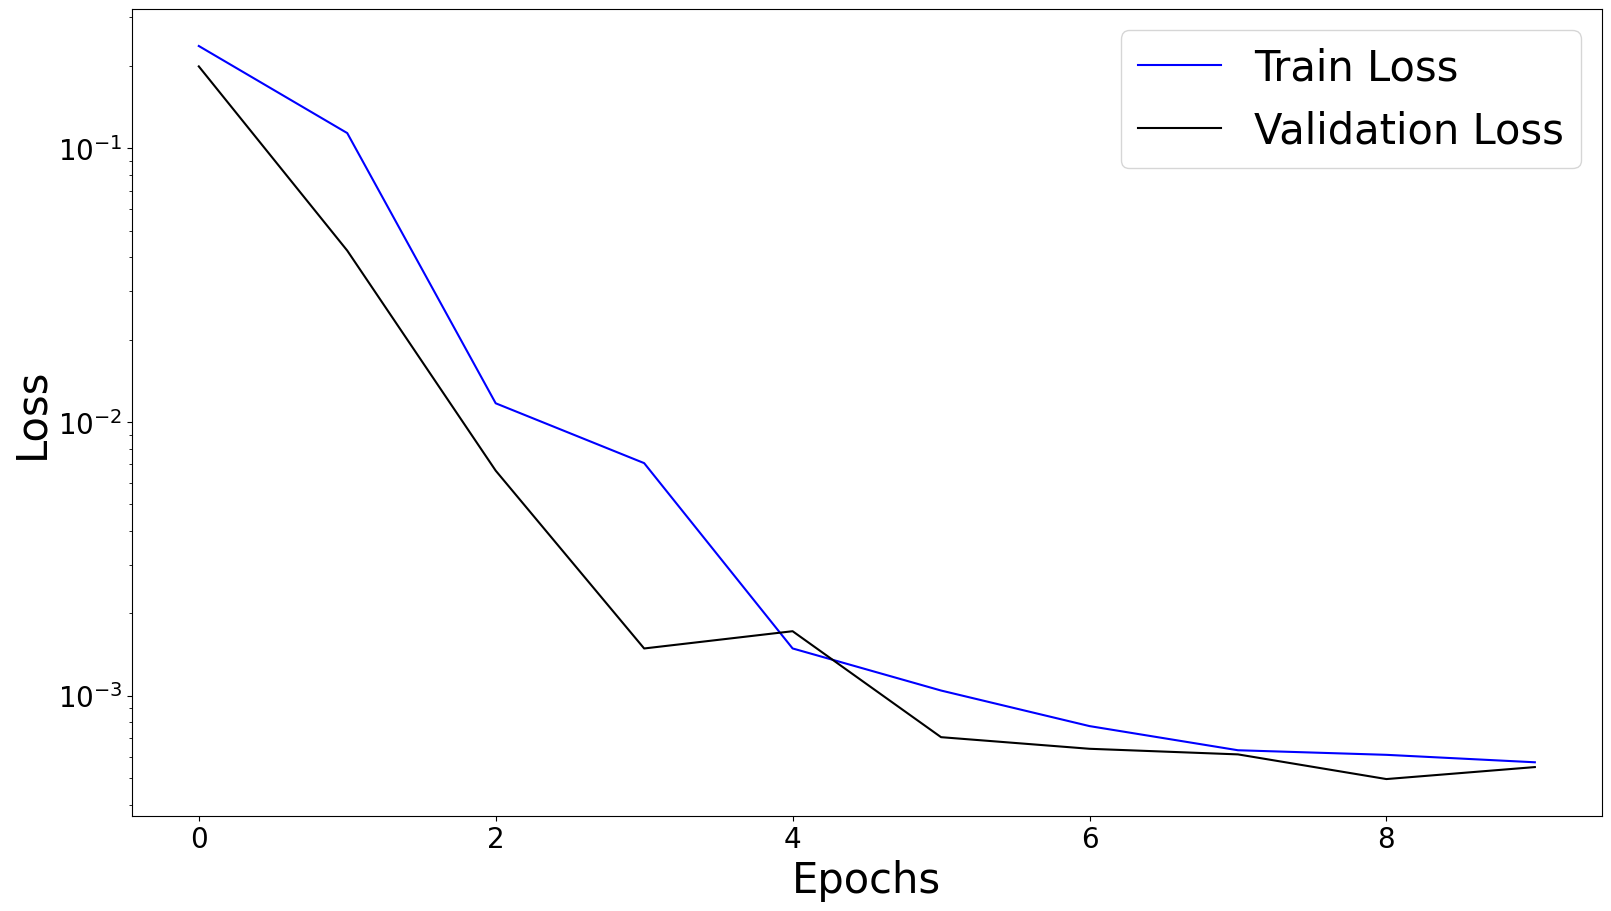

In [11]:
fig = plt.figure(figsize=(16, 9), constrained_layout=True)
axes = fig.gca()
axes.plot(np.arange(net.get_epochs()), net.losses[0], color='b', label='Train Loss')
axes.plot(np.arange(net.get_epochs()), net.losses[1], color='k', label='Validation Loss')
axes.set_yscale('log')
axes.set_xlabel('Epochs', fontsize=30)
axes.set_ylabel('Loss', fontsize=30)
axes.tick_params(which='both', labelsize=20)
axes.legend(fontsize=30)

# Plotting Predictions and Targets
Finally, we can visualise the performance of our network by plotting the predictions against the targets, which should be a 1-1 line.
The predictions come from `data['preds']` and the targets from `data['targets']`, which were both returned when we generated the predictions.

Text(0, 0.5, 'Predictions')

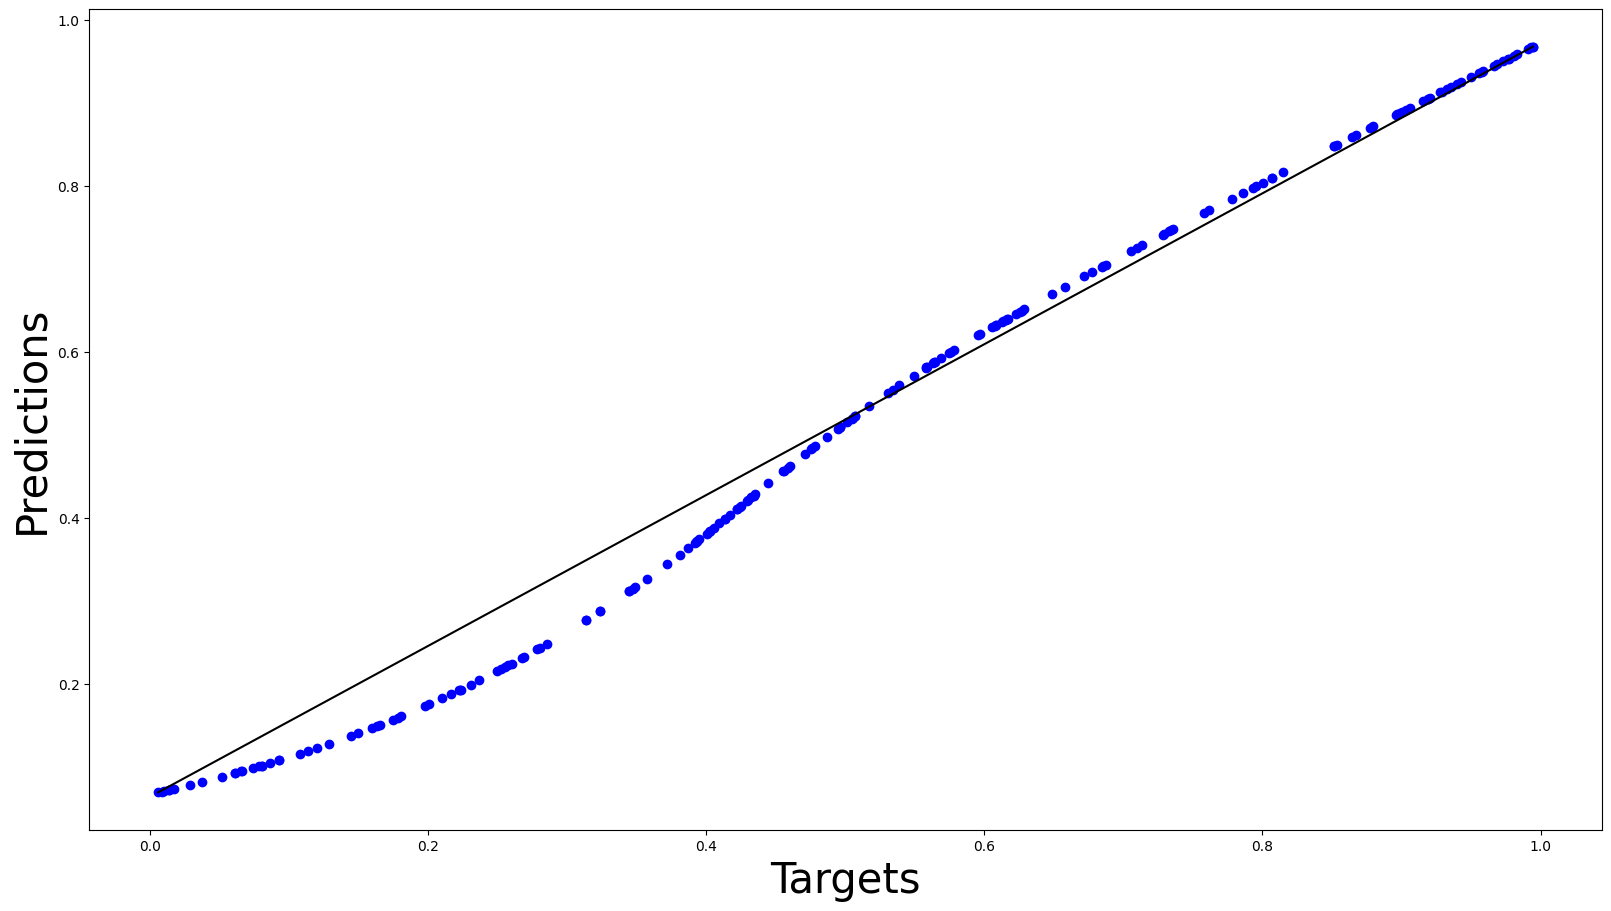

In [12]:
fig = plt.figure(figsize=(16, 9), constrained_layout=True)
axes = fig.gca()
axes.scatter(data['targets'].flatten(), data['preds'].flatten(), color='b')
axes.plot([np.min(data['targets']), np.max(data['targets'])], [np.min(data['preds']), np.max(data['preds'])], color='k')
axes.set_xlabel('Targets', fontsize=30)
axes.set_ylabel('Predictions', fontsize=30)
